# Introduction
This notebook covers my first approach to the Titanic: Machine Learning from Disaster competition (check it out [here](http://www.kaggle.com/c/titanic) for more details).  
As a beginner, my goal was to score over 80% with basic feature engineering and a simple model and I eventually made it with great satisfaction and hard work.  
For those of you who want to do the same without overcomplicating things, I will guide you through this process and hopefully help you in some way.  
Let's get started!  
![](https://www.ilmessaggero.it/photos/MED_HIGH/34/78/2383478_1527_titanic.jpg)
# Importing packages and data
We begin by loading our standard modules and taking a look at the data.

In [1]:
import pandas as pd 
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('dark')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
print('Setup complete')

Setup complete


In [2]:
# Load and display train data
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# Load and display test data
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


We then check for missing values in both training and test data.

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Values in `Age`, `Cabin` and `Embarked` are missing in the train data, while values in `Age`, `Fare` and `Cabin` are missing in the test data.  
If needed, we will take care of those later.  
Finally, just to have an idea of what we are going to predict, we focus on the target: let's see how many passengers survived.

In [6]:
train_data['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

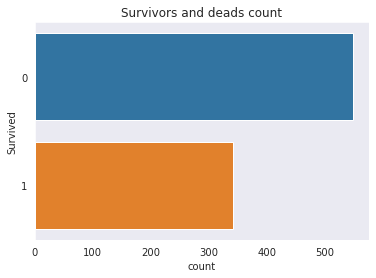

In [7]:
g = sns.countplot(y=train_data['Survived']).set_title('Survivors and deads count')

We see that in the training data only around 38.4% of the passengers managed to survive the disaster: this is an important value that we have to keep in mind.
# Feature analysis and creation
The goal of this section is to gain a general understanding of our data to perform a more precise feature selection in the modeling part.  
We will thus explore one feature at a time in order to determine its importance in predicting if a passenger survived or not.
## Sex
We see that around 65% of the passengers were male while the remaining 35% were female.  
The important thing to notice here is that the survival rate for women was four times the survival rate for men and this makes `Sex` one of the most informative features.  
It is not a case that the gender submission on its own scores 0.76555!

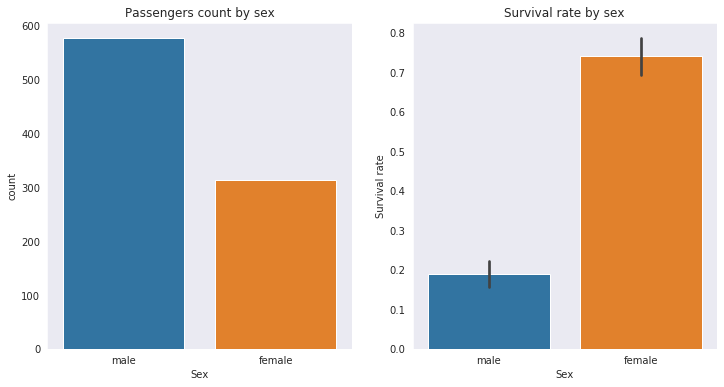

In [8]:
fig, axarr = plt.subplots(1, 2, figsize=(12,6))
a = sns.countplot(train_data['Sex'], ax=axarr[0]).set_title('Passengers count by sex')
axarr[1].set_title('Survival rate by sex')
b = sns.barplot(x='Sex', y='Survived', data=train_data, ax=axarr[1]).set_ylabel('Survival rate')

## Pclass
There were three classes on the ship and from the plot we see that the number of passengers in the third class was higher than the number of passengers in the first and second classes combined.  
However, the survival rate by class is not the same: more than 60% of first-class passengers and around half of the second class passengers were rescued, whereas 75% of third class passengers were not able to survive the disaster.  
For this reason, this is definitely an important aspect to consider.

In [9]:
train_data.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

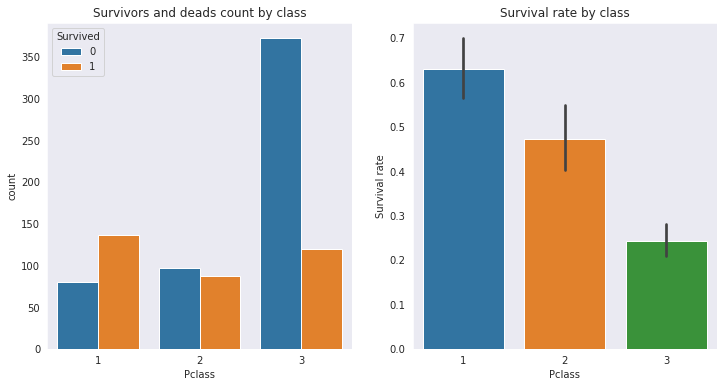

In [10]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(x='Pclass', hue='Survived', data=train_data, ax=axarr[0]).set_title('Survivors and deads count by class')
axarr[1].set_title('Survival rate by class')
b = sns.barplot(x='Pclass', y='Survived', data=train_data, ax=axarr[1]).set_ylabel('Survival rate')

We can also see the survival rate by `Sex` and `Pclass`, which is quite impressive: first class and second class women who were rescued were respectively 97% and 92%, while the percentage drops to 50% for third-class women.  
Despite that, this is still more than the 37% survival rate for first-class men. 

In [11]:
train_data.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

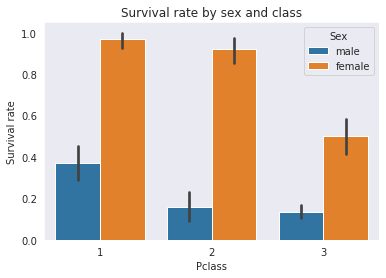

In [12]:
plt.title('Survival rate by sex and class')
g = sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_data).set_ylabel('Survival rate')

## Age
Despite this column contains a lot of missing values, we see that in the training data the average age was just under 30 years.  
Here is the plot of the age distribution in general compared to the one for the survivors and the deads.

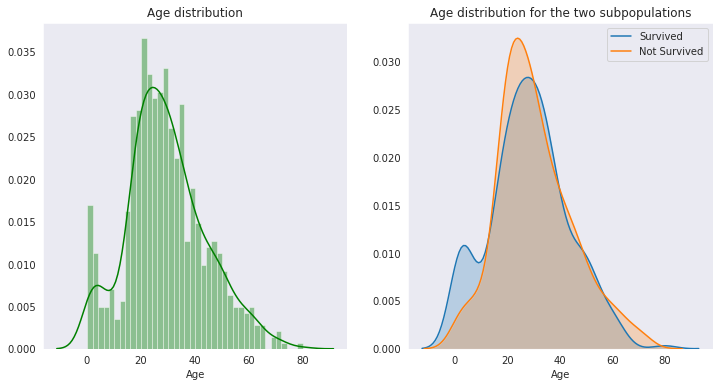

In [13]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
axarr[0].set_title('Age distribution')
f = sns.distplot(train_data['Age'], color='g', bins=40, ax=axarr[0])
axarr[1].set_title('Age distribution for the two subpopulations')
g = sns.kdeplot(train_data['Age'].loc[train_data['Survived'] == 1], 
                shade= True, ax=axarr[1], label='Survived').set_xlabel('Age')
g = sns.kdeplot(train_data['Age'].loc[train_data['Survived'] == 0], 
                shade=True, ax=axarr[1], label='Not Survived')

At a first look, the relationship between `Age` and `Survived` appears not to be very clear: we notice for sure that there is a peak corresponding to young passengers for those who survived, but apart from that the rest is not very informative.  
We can appreciate this feature more if we consider `Sex` too: now it is clearer that a good number of male survivors had less than 12 years, while the female group has no particular properties.

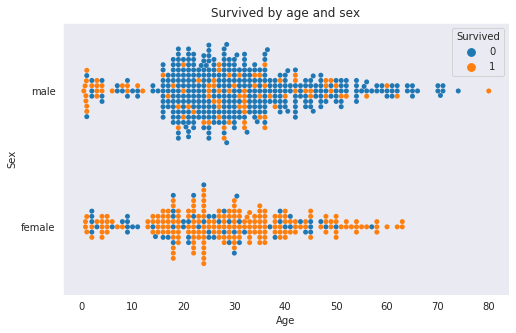

In [14]:
plt.figure(figsize=(8,5))
g = sns.swarmplot(y='Sex', x='Age', hue='Survived', data=train_data).set_title('Survived by age and sex')

Another interesting thing to look at is the relation between `Age`, `Pclass` and `Survived`.  
We see the influence of `Pclass` is the important one as there are no super clear horizontal patterns.  
Also, we note that there were not many children in the first class.

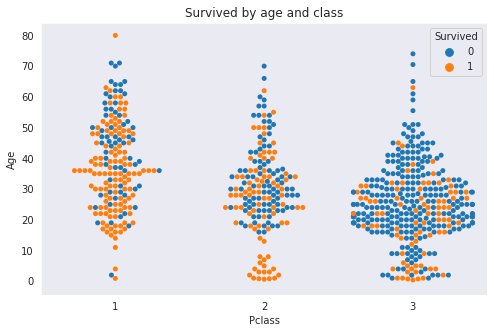

In [15]:
plt.figure(figsize=(8,5))
h = sns.swarmplot(x='Pclass', y='Age', hue='Survived', data=train_data).set_title('Survived by age and class')

After all these plots I am not sure about the importance of `Age` in a model: I guess we will see later, even though I am thinking of not using it.
## Fare
From the description, we see that the `Fare` distribution is positively skewed, with 75% of data under 31 and a maximum of 512.  
Just to understand better this feature, the simplest idea here could be creating fare ranges using quartiles.  
At a first look, we notice that the higher the fare, the higher the possibility of surviving.

In [16]:
train_data.Fare.describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

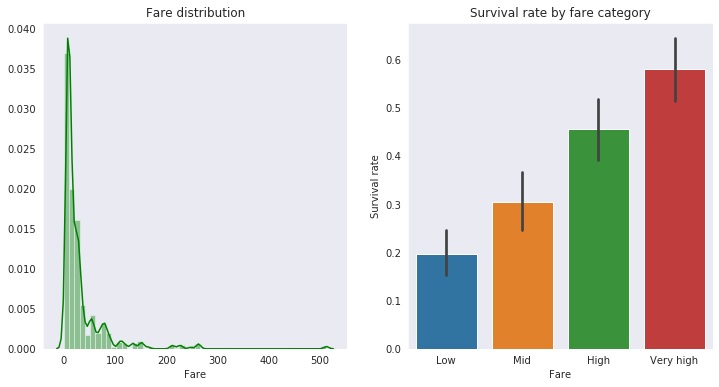

In [17]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
f = sns.distplot(train_data.Fare, color='g', ax=axarr[0]).set_title('Fare distribution')
fare_ranges = pd.qcut(train_data.Fare, 4, labels = ['Low', 'Mid', 'High', 'Very high'])
axarr[1].set_title('Survival rate by fare category')
g = sns.barplot(x=fare_ranges, y=train_data.Survived, ax=axarr[1]).set_ylabel('Survival rate')

However, when it came down to modeling, these fare categories did not help at all as they underfit quite substantially.  
Looking at the more detailed plot below, we also see for example that all males with fare between 200 and 300 died: that is not what we would expect.  
For this reason, I left the `Fare` feature as it is in order to prevent losing too much information: at deeper levels of a tree, a more discriminant relationship might open up and it could become a good group detector.

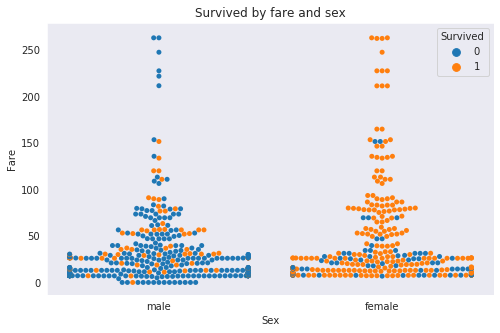

In [18]:
plt.figure(figsize=(8,5))
# I excluded the three outliers with fare > 500 from this plot
a = sns.swarmplot(x='Sex', y='Fare', hue='Survived', data=train_data.loc[train_data.Fare<500]).set_title('Survived by fare and sex')

After seeing Erik's kernel [here](https://www.kaggle.com/erikbruin/titanic-2nd-degree-families-and-majority-voting), it reminded me I had not analyzed this feature deep enough.  
When I printed the description, I should have also noticed that the minimum value for `Fare` is zero and that is a bit strange.  
Is this information correct? Let's see who these passengers are.

In [19]:
train_data.loc[train_data.Fare==0]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S
466,467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S


Since some of them are first or second class passengers, I decided to remove zero-Fares that might confuse my model.  
With the help of this function, we are going to set null values every time we encounter a zero value for `Fare`.  
Those will be imputed later when we train our model.

In [20]:
def remove_zero_fares(row):
    if row.Fare == 0:
        row.Fare = np.NaN
    return row
# Apply the function
train_data = train_data.apply(remove_zero_fares, axis=1)
test_data = test_data.apply(remove_zero_fares, axis=1)
# Check if it did the job
print('Number of zero-Fares: {:d}'.format(train_data.loc[train_data.Fare==0].shape[0]))

Number of zero-Fares: 0


## Embarked 
`Embarked` tells us where a passenger boarded from.  
There are three possible values for it: Southampton, Cherbourg and Queenstown.  
In the training data, more than 70% of the people boarded from Southampton, slightly under 20% from Cherbourg and the rest from Queenstown.  
Counting survivors by boarding point, we see that more people who embarked from Cherbourg survived than those who died.

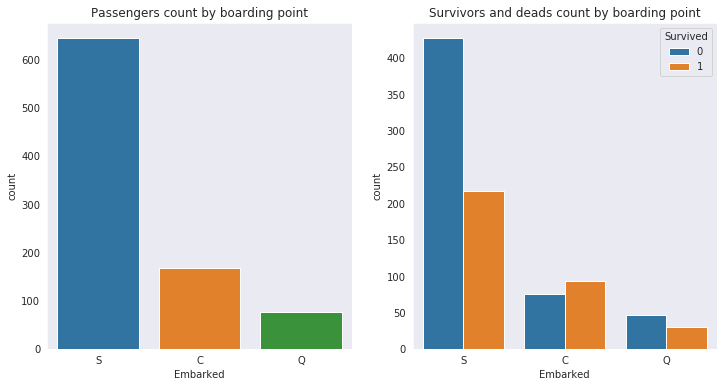

In [21]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
sns.countplot(train_data['Embarked'], ax=axarr[0]).set_title('Passengers count by boarding point')
p = sns.countplot(x = 'Embarked', hue = 'Survived', data = train_data, 
                  ax=axarr[1]).set_title('Survivors and deads count by boarding point')

Since we don't expect that a passenger's boarding point could change the chance of surviving, we guess this is probably due to the higher proportion of first and second class passengers for those who came from Cherbourg rather than Queenstown and Southampton.  
To check this, we see the class distribution for the different embarking points.

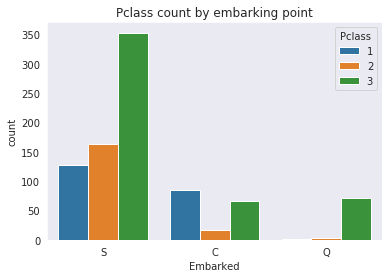

In [22]:
g = sns.countplot(data=train_data, x='Embarked', hue='Pclass').set_title('Pclass count by embarking point')

The claim is correct and hopefully justifies why that survival rate is so high.  
Again this feature might be useful in detecting groups at a deeper level of a tree and this is the only reason why I keep it.
## Name
The `Name` column contains useful information as for example we could identify family groups using surnames.  
In this notebook, however, I extracted only the passengers' title from it, creating a new feature for both train and test data.

In [23]:
train_data['Title'] = train_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
test_data['Title'] = test_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [24]:
train_data['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Jonkheer          1
Mme               1
Sir               1
Capt              1
Lady              1
the Countess      1
Don               1
Ms                1
Name: Title, dtype: int64

In [25]:
test_data['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dona        1
Dr          1
Ms          1
Name: Title, dtype: int64

Looking at the distribution of the titles, it might be convenient to move the really low-frequency ones into bigger groups.  
After analyzing them, I substituted all rare female titles with Miss and all rare male titles with Mr.

In [26]:
# Substitute rare female titles
train_data['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
test_data['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
# Substitute rare male titles
train_data['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
test_data['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

Here is the final result. I have relatively high hopes for this new feature since the survival rate in most cases appears to be either significantly above or below the average survival rate, which should help our model.

In [27]:
train_data.groupby('Title').Survived.mean()

Title
Dr        0.428571
Master    0.575000
Miss      0.707447
Mr        0.160000
Mrs       0.792000
Rev       0.000000
Name: Survived, dtype: float64

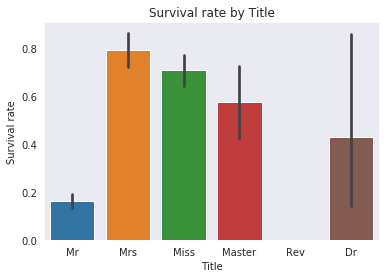

In [28]:
plt.title('Survival rate by Title')
g = sns.barplot(x='Title', y='Survived', data=train_data).set_ylabel('Survival rate')

## Cabin and Ticket
The `Cabin` feature is somewhat problematic as there are many missing values.  
I don't expect it to help our model too much so I don't even analyze it.  
On the other side, a correctly engineered `Ticket` column is the best way to find family groups but it is not the approach I chose for this notebook (I will maybe try it in another one).  
Since it is a pity to delete it knowing its full potential, I decided to create two new columns: one for the ticket first two letters and the second one for the ticket length.

In [29]:
# Extract the first two letters
train_data['Ticket_lett'] = train_data.Ticket.apply(lambda x: x[:2])
test_data['Ticket_lett'] = test_data.Ticket.apply(lambda x: x[:2])
# Calculate ticket length
train_data['Ticket_len'] = train_data.Ticket.apply(lambda x: len(x))
test_data['Ticket_len'] = test_data.Ticket.apply(lambda x: len(x))

This should help our model a little, so I think we are fine here.
## SibSp
`SibSp` is the number of siblings or spouses of a person aboard the Titanic.  
We see that more than 90% of people traveled alone or with one sibling or spouse.  
The survival rate between the different categories is a bit confusing but we see that the chances of surviving are lower for those who traveled alone or with more than 2 siblings.  
Furthermore, we notice that no one from a big family with 5 or 8 siblings was able to survive.

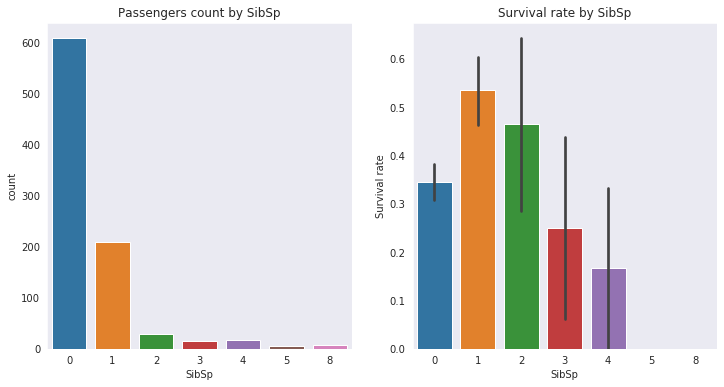

In [30]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(train_data['SibSp'], ax=axarr[0]).set_title('Passengers count by SibSp')
axarr[1].set_title('Survival rate by SibSp')
b = sns.barplot(x='SibSp', y='Survived', data=train_data, ax=axarr[1]).set_ylabel('Survival rate')

## Parch
Similar to the `SibSp` column, this feature contains the number of parents or children each passenger was traveling with.  
Here we draw the same conclusions as `SibSp`: we see again that small families had more chances to survive than bigger ones and passengers who traveled alone.

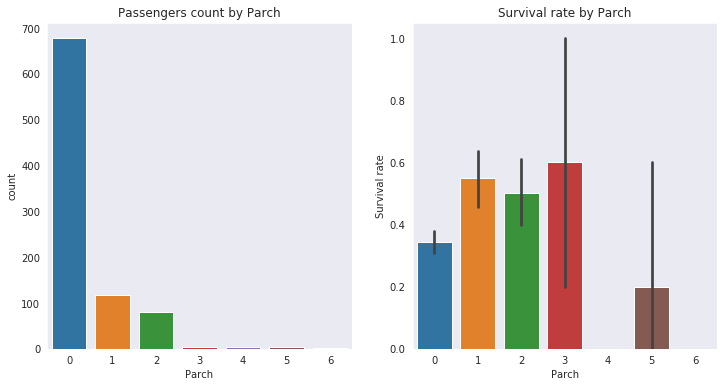

In [31]:
fig, axarr = plt.subplots(1,2,figsize=(12,6))
a = sns.countplot(train_data['Parch'], ax=axarr[0]).set_title('Passengers count by Parch')
axarr[1].set_title('Survival rate by Parch')
b = sns.barplot(x='Parch', y='Survived', data=train_data, ax=axarr[1]).set_ylabel('Survival rate')

## Family type
Since we have two seemingly weak predictors, one thing we can do is combine them to get a stronger one.  
In the case of `SibSp` and `Parch`, we can join the two variables to get a family size feature, which is the sum of `SibSp`, `Parch` and 1 (who is the passenger himself). 

In [32]:
# Creation of a new Fam_size column
train_data['Fam_size'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['Fam_size'] = test_data['SibSp'] + test_data['Parch'] + 1

Plotting the survival rate by family size it is clear that people who were alone had a lower chance of surviving than families up to 4 components, while the survival rate drops for bigger families and ultimately becomes zero for very large ones.

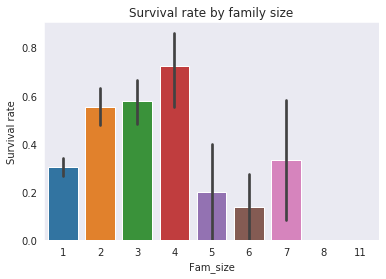

In [33]:
plt.title('Survival rate by family size')
g = sns.barplot(x='Fam_size', y='Survived', data=train_data).set_ylabel('Survival rate')

To further summarize the previous trend, as my final feature I created four groups for family size.

In [34]:
# Creation of four groups
train_data['Fam_type'] = pd.cut(train_data.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
test_data['Fam_type'] = pd.cut(test_data.Fam_size, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

Here is the final result: I think we discovered a nice pattern.

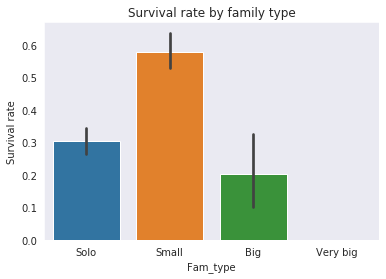

In [35]:
plt.title('Survival rate by family type')
g = sns.barplot(x=train_data.Fam_type, y=train_data.Survived).set_ylabel('Survival rate')

After all these considerations it is finally time to put everything together in a simple and quite efficient model.
# Modeling
We start by selecting the features we will use and isolating the target.  
As I said, I will not consider `Cabin` and in the end, I also excluded `Age` as the relevant information which is being a young man is encoded in the Master title.  
I also did not use `Sex` as it is not useful given the `Title` column: adult males and young children have the same sex but are really different categories as we saw before, so we don't want to confuse our algorithm.  
If you don't extract the `Title` column, remember to put `Sex` in your models as it is pretty important!

In [36]:
y = train_data['Survived']
features = ['Pclass', 'Fare', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_lett']
X = train_data[features]
X.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_lett
0,3,7.2500,Mr,S,Small,9,A/
1,1,71.2833,Mrs,C,Small,8,PC
2,3,7.9250,Miss,S,Solo,16,ST
3,1,53.1000,Mrs,S,Small,6,11
4,3,8.0500,Mr,S,Solo,6,37


Since from the EDA I remember that we have missing values in both train and test data and multiple categorical variables to deal with, I decided to use pipelines to simplify all the work.

In [37]:
numerical_cols = ['Fare']
categorical_cols = ['Pclass', 'Title', 'Embarked', 'Fam_type', 'Ticket_len', 'Ticket_lett']

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Bundle preprocessing and modeling code 
titanic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(random_state=0, n_estimators=500, max_depth=5))
])

# Preprocessing of training data, fit model 
titanic_pipeline.fit(X,y)

print('Cross validation score: {:.3f}'.format(cross_val_score(titanic_pipeline, X, y, cv=10).mean()))

Cross validation score: 0.826


We are now ready to make our predictions by simply calling the predict method on the test data.

In [38]:
X_test = test_data[features]
X_test.head()

,Pclass,Fare,Title,Embarked,Fam_type,Ticket_len,Ticket_lett
0,3,7.8292,Mr,Q,Solo,6,33
1,3,7.0000,Mrs,S,Small,6,36
2,2,9.6875,Mr,Q,Solo,6,24
3,3,8.6625,Mr,S,Solo,6,31
4,3,12.2875,Mrs,S,Small,7,31


In [39]:
# Preprocessing of test data, get predictions
predictions = titanic_pipeline.predict(X_test)

All we have to do now is convert them into the submission file!

In [40]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!


# Conclusion
This was my very first Kaggle competition and climbing up the leaderboard one step at a time was definitely a really nice journey.  
Below you can find a histogram of Titanic LB scores in September 2020: right now, this notebook places in top 4%.
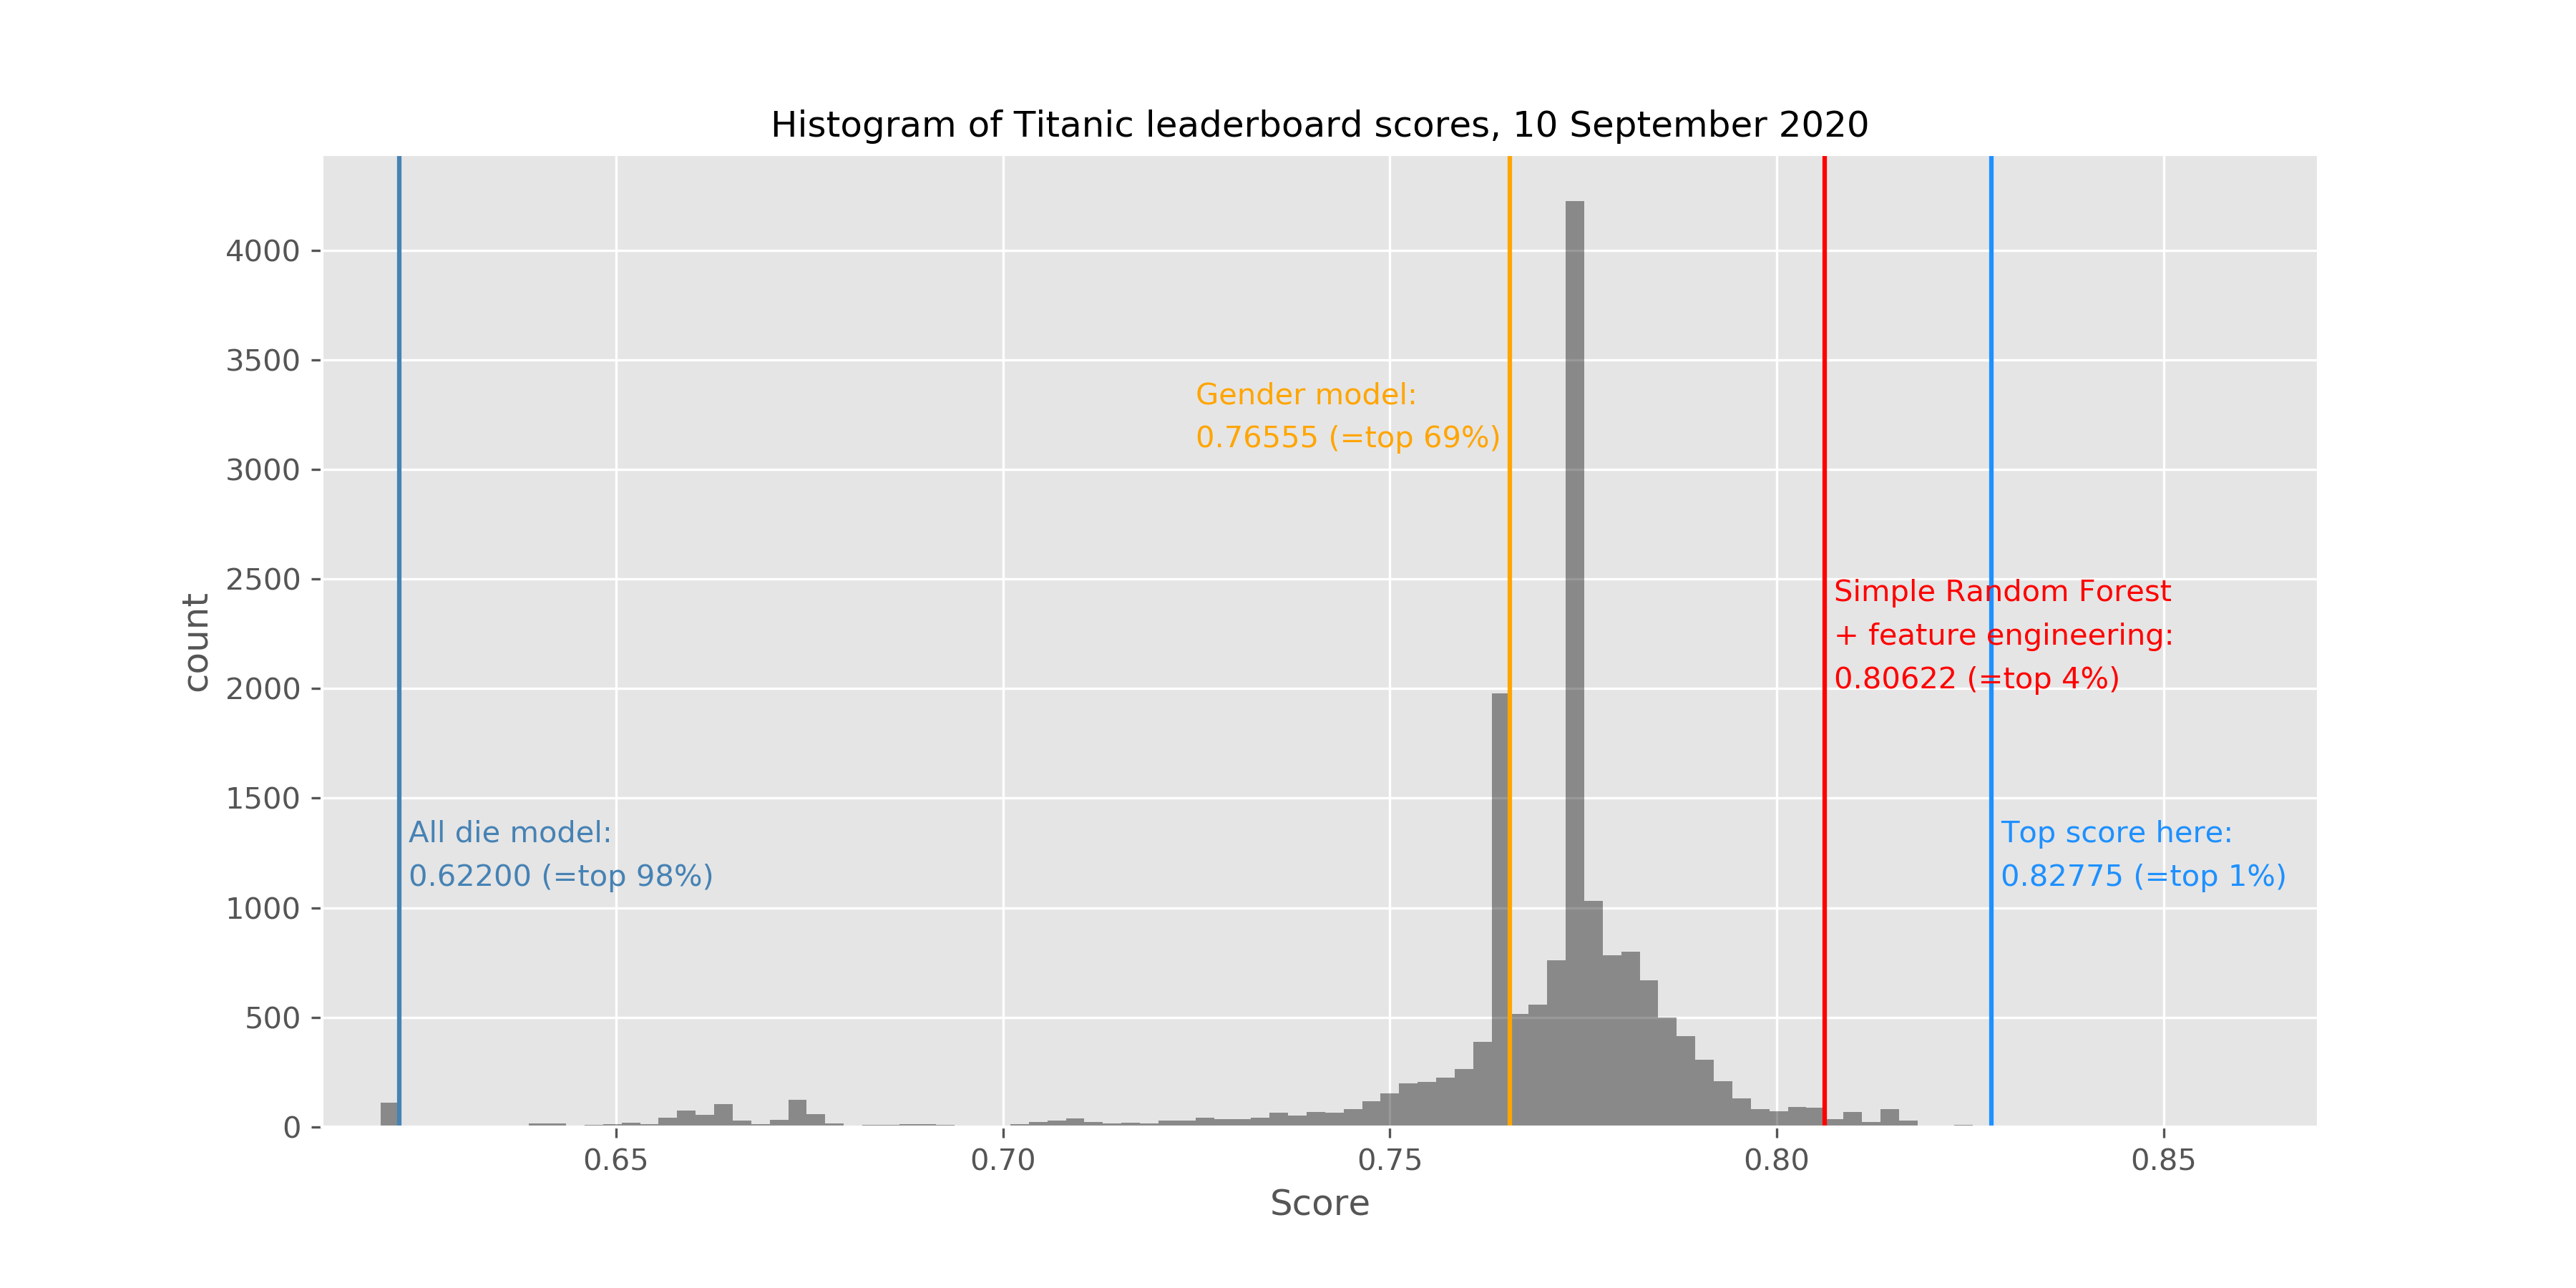
This is a very good score, but we can still improve our classifier with a clever grouping approach and ensembling models.  
If you are interested in how to do this, [here](https://www.kaggle.com/mviola/titanic-wcg-knns-ensemble-0-82775-top-1) you can find my other notebook that reaches 0.82775 (you might want to check [this](https://www.kaggle.com/c/titanic/discussion/179147) out as well to have an idea of some of the top scores now).  
For the moment, let me know if you found this notebook useful or you just liked it: I would really appreciate it!  
Good luck with this competition and see you in the next one.